## Neural Style Transfer Application##

###Multimedia Retrieval Final Project###
### Group 14###
liyu7088(4801317999), rlin5842(480509930)

Our application is to apply neural style transfer to combine a content image with the style features of the style image. We would use convolutional neural networks and import pre-trained VGG19 to detect features from the images. Running on the cloud GPU of colab allows us to have a shorter runtime.

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools


In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

import os # just to play sound through our iteration

In [0]:
# The only thing to change in our application, the name of the images.
content_name = 'shaq.jpg'
style_name = 'Weeping-Woman.jpg'

In [0]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
def load_img(image_name):
    max_dim = 512
    img = Image.open(image_name)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    
    img = kp_image.img_to_array(img)
    
    # Get bacth dimension
    img = np.expand_dims(img, axis=0)
    return img

In [0]:
def imshow(img, title=None):
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

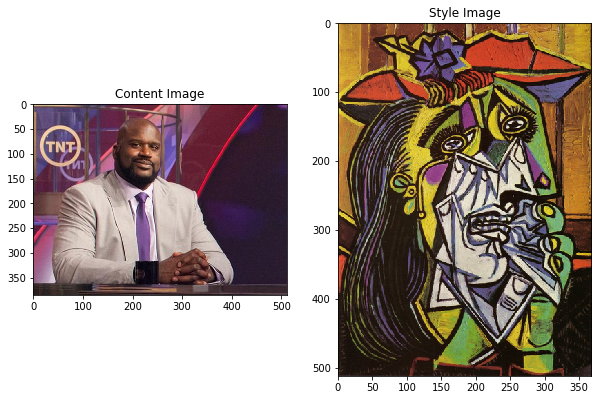

In [0]:
# Show our images
plt.figure(figsize=(10,10))

content = load_img(content_name).astype('uint8')
style = load_img(style_name).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Now we prepare the data ##


In [0]:
def load_and_process_img(image_name):
    img = load_img(image_name)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [0]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input")
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# img = load_and_process_img(content_name)
# print(img.shape)
# deprocess_img(img)

(1, 385, 512, 3)


array([[[115,  71,  92],
        [112,  70,  93],
        [111,  71,  98],
        ...,
        [131,  69, 142],
        [130,  68, 141],
        [130,  68, 141]],

       [[162, 121, 119],
        [161, 121, 123],
        [157, 121, 125],
        ...,
        [133,  71, 144],
        [131,  69, 142],
        [131,  69, 142]],

       [[213, 173, 141],
        [210, 174, 143],
        [208, 173, 149],
        ...,
        [136,  72, 148],
        [136,  73, 148],
        [136,  73, 148]],

       ...,

       [[ 52,  40,  42],
        [ 47,  35,  38],
        [ 43,  31,  31],
        ...,
        [ 96,  79,  87],
        [ 97,  80,  88],
        [ 97,  80,  88]],

       [[ 53,  41,  43],
        [ 47,  35,  38],
        [ 43,  31,  31],
        ...,
        [ 75,  58,  66],
        [ 78,  61,  69],
        [ 78,  61,  69]],

       [[ 55,  43,  45],
        [ 49,  37,  40],
        [ 45,  33,  33],
        ...,
        [ 48,  31,  39],
        [ 50,  33,  41],
        [ 50,  33,  41]]

## Intermediate layer

In [0]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build Model

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

## Compute Loss ##
### Content Loss, Style Loss ###

In [0]:
# Content Loss
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [0]:
# Style Loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram/tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

## Gradient Descent ##

In [0]:
# Get feuatures
def get_feature_representation(model, content_name, style_name):
    # Load image
    content_image = load_and_process_img(content_name)
    style_image = load_and_process_img(style_name)
    
    # Compute batch
    content_outputs = model(content_image)
    style_outputs = model(style_image)
    
    # Get features
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features
    

In [0]:
# Compute Loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """
    Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
 
    """
    style_weight, content_weight = loss_weights
    
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    weight_per_style_layer = 1.0/float(num_style_layers)
    # Get style loss from all layers
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer*get_style_loss(comb_style[0], target_style)
    # Get content loss from all layers
    weight_per_content_layer = 1.0/float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer*get_content_loss(comb_content[0], target_content)
    
    
    style_score *= style_weight
    content_score *= content_weight
    loss = style_score + content_score
     
    return loss, style_score, content_score
         

In [0]:
# Compute Gradient
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

## Optimization loop ##

Here we have our model, now we run iterations, to update the best loss, and the best image. Through our iterations, we collect the data of losses to further analyze our algorithms and the result.

In [0]:
import IPython.display

def run_style_transfer(content_name,
                      style_name,
                      num_iterations=1000,
                      content_weight=1e3,
                      style_weight=1e-2):
    model = get_model()
    # Don't want to train our layers in the model
    for layer in model.layers:
        layer.trainable = False
    
    # Get features
    style_features, content_features = get_feature_representation(model, content_name, style_name)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    # Set initial image
    init_image = load_and_process_img(content_name)
    init_image = tfe.Variable(init_image, dtype=tf.float32)
    
    # Create optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    # To display images intermediately
    iter_count = 1
    
    # Store the best results
    best_loss, best_img = float('inf'), None
    
    # Create a nice config
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model':model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features}
    
    # Display
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols) # here 100
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68]) # From VGG19
    min_vals = -norm_means
    max_vals = 225 - norm_means
    
    imgs = []
    iterations_list = []
    total_loss = []
    style_loss_list = []
    content_loss_list = []
    time_list = []
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()
        
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())
        if i % display_interval == 0:
            start_time = time.time()
            
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iterations: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time()-start_time))
            iterations_list.append(i)
            total_loss.append(loss)
            style_loss_list.append(style_score)
            content_loss_list.append(content_score)
            time_list.append(time.time()-start_time)
            # play sound for the iteration
            os.system('afplay /System/Library/Sounds/Sosumi.aiff')
            #os.system('say "you finished 100 iterations",')
            print('Total running time till now: %.4f s' % (time.time()-global_start))
    print('Total time: {:.4f}s'.format(time.time()-global_start))
    
    # store all the transfer stats
    output_stats = []
    for i in range(len(iterations_list)):
        stats = 'Iterations: %d, Time: %.4f s\nTotal loss: %.4e, Style loss: %.4e, Content loss: %.4e\n' % (iterations_list[i], time_list[i], total_loss[i], style_loss_list[i], content_loss_list[i])
        output_stats.append(stats)
    output_stats.append('Total time %.4f s' % (time.time()-global_start))
    
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    length = len(imgs)
    for i, img in enumerate(imgs):
        if i==length-1:
            plt.savefig('process0.jpg')
        plt.subplot(num_rows, num_cols, i+1)        
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss, output_stats 
       
            
            

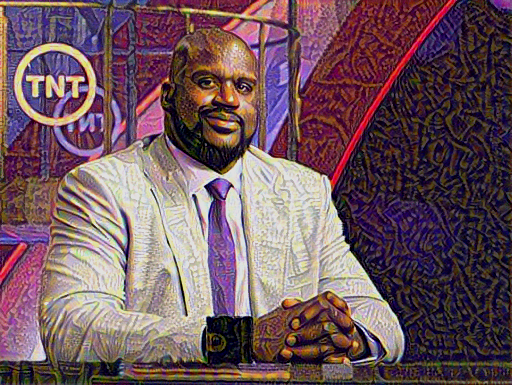

Iterations: 10
Total loss: 6.1495e+07, style loss: 5.9488e+07, content loss: 2.0073e+06, time: 0.0716s
Total running time till now: 2.9102 s


In [0]:
best, best_loss, output_stats = run_style_transfer(content_name, style_name, num_iterations=100)
os.system('say "you finished your program"') 

In [0]:
for stats in output_stats:
    print(stats)

Iterations: 0, Time: 0.0922 s
Total loss: 4.2939e+08, Style loss: 4.2939e+08, Content loss: 0.0000e+00

Iterations: 100, Time: 0.0754 s
Total loss: 9.2325e+06, Style loss: 7.2364e+06, Content loss: 1.9961e+06

Iterations: 200, Time: 0.0650 s
Total loss: 4.5460e+06, Style loss: 3.0377e+06, Content loss: 1.5083e+06

Iterations: 300, Time: 0.0702 s
Total loss: 2.8577e+06, Style loss: 1.6613e+06, Content loss: 1.1964e+06

Iterations: 400, Time: 0.0649 s
Total loss: 2.1255e+06, Style loss: 1.1457e+06, Content loss: 9.7975e+05

Iterations: 500, Time: 0.0631 s
Total loss: 1.7407e+06, Style loss: 8.9868e+05, Content loss: 8.4200e+05

Iterations: 600, Time: 0.0634 s
Total loss: 1.5127e+06, Style loss: 7.6410e+05, Content loss: 7.4859e+05

Iterations: 700, Time: 0.0716 s
Total loss: 1.3653e+06, Style loss: 6.8112e+05, Content loss: 6.8419e+05

Iterations: 800, Time: 0.0616 s
Total loss: 1.2615e+06, Style loss: 6.2413e+05, Content loss: 6.3735e+05

Iterations: 900, Time: 0.0621 s
Total loss: 1.18

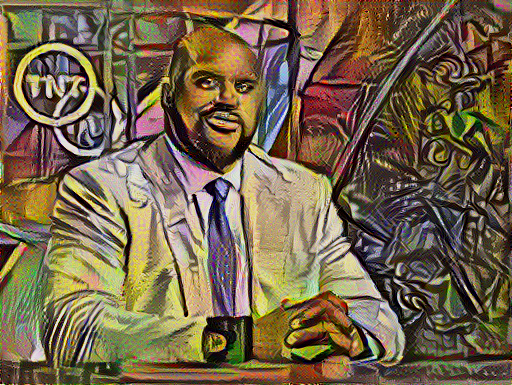

In [0]:
Image.fromarray(best)

## Visualize outputs ##

In [0]:
def show_results(best_img, content_name, style_name, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_name)
    style = load_img(style_name)
    
    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')
    
    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')
    
    if show_large_final:
        plt.figure(figsize=(10, 10))
        plt.imshow(best_img)
        plt.title('Output Image')
        #plt.savefig('output.jpg')
        plt.savefig('output_0.jpg', bbox_inches='tight')
        plt.show()
        


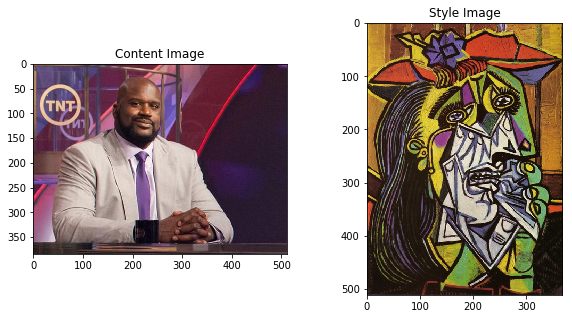

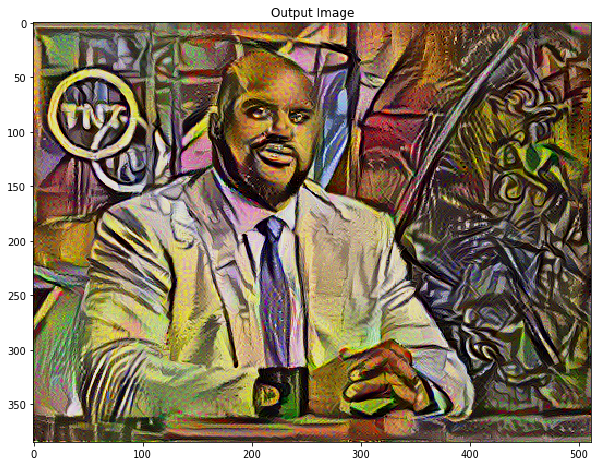

In [0]:

show_results(best, content_name, style_name)